In [1]:
import xarray as xr
import numpy as np
from xgcm.grid import Grid
import matplotlib.pyplot as plt

In [2]:
RC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RC.data', dtype='>f4')
RAC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RAC.data', dtype='>f4').reshape(2160,2160)
RAZ =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RAZ.data', dtype='>f4').reshape(2160,2160)
RF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RF.data', dtype='>f4')
DRC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRC.data', dtype='>f4')
DXG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4').reshape(2160,2160)
DYG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4').reshape(2160,2160)
DXC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4').reshape(2160,2160)
DYC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4').reshape(2160,2160)
XG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XG.data', dtype='>f4').reshape(2160,2160)
YG =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YG.data', dtype='>f4').reshape(2160,2160)
XC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XC.data', dtype='>f4').reshape(2160,2160)
YC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4').reshape(2160,2160)
DRF =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DRF.data', dtype='>f4')
hFacC =np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/hFacC.data', dtype='>f4').reshape(-1,2160,2160)

In [3]:
# Load Eulerian data
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel.zarr')

uvel_merged = uvel_merged.isel(time=slice(771-42,900)).isel(k=0)

vvel_merged = vvel_merged.isel(time=slice(771-42,900)).isel(k=0)

uvel_merged = uvel_merged.drop_vars('time')
vvel_merged = vvel_merged.drop_vars('time')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [4]:
def lanczos(x, a):
    return np.sinc(x/a)

In [5]:
window_width=20
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])

In [6]:
nofiles=49
u_eul_filtered = uvel_merged.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
v_eul_filtered = vvel_merged.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
u_eul_filtered = u_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_filtered = v_eul_filtered.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
u_eul_unfiltered = uvel_merged.U.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
v_eul_unfiltered = vvel_merged.V.sel(time=slice(42,42+nofiles)).assign_coords({'time':np.arange(0,nofiles)*3600})
#u_eul_filtered = grid.interp(grid.interp(u_eul_filtered,'X'),'X')
#v_eul_filtered = grid.interp(grid.interp(v_eul_filtered,'Y'),'Y')

In [7]:
#Load Lag data
lag_unfiltered = xr.open_zarr('/swot/SUM03/spencer/time_2_vels/lag_unfiltered_time2.zarr')
lag_filtered = xr.open_zarr('/swot/SUM03/spencer/time_2_vels/lag_filtered_time2.zarr')
u_unfiltered = grid.interp(lag_unfiltered['u'],'X')
v_unfiltered = grid.interp(lag_unfiltered['v'],'Y')
u_filtered = grid.interp(lag_filtered['u'],'X')
v_filtered = grid.interp(lag_filtered['v'],'Y')

In [8]:
eul_filtered_vels = xr.open_zarr('/swot/SUM03/spencer/agulhas_vels/eul_filtered_vels.zarr')
ds = eul_filtered_vels
grid = Grid(ds,coords={'X': {'center': 'i', 'left': 'i_g'},'Y': {'center': 'j', 'left': 'j_g'}})
ds = ds.assign_coords({"raZ":(["j_g","i_g"],RAZ)})
ds = ds.assign_coords({"dxC":(["j","i_g"],DXC)})
ds = ds.assign_coords({"dyC":(["j_g","i"],DYC)})

In [9]:
eul_unf_utransport = u_eul_unfiltered*ds.dyG*ds.hFacW*ds.drF
eul_unf_vtransport = v_eul_unfiltered*ds.dxG*ds.hFacS*ds.drF

unf_utransport = u_unfiltered*ds.dyG*ds.hFacW*ds.drF
unf_vtransport = v_unfiltered*ds.dxG*ds.hFacS*ds.drF

eul_utransport = u_eul_filtered*ds.dyG*ds.hFacW*ds.drF
eul_vtransport = v_eul_filtered*ds.dxG*ds.hFacS*ds.drF

filt_utransport = u_filtered*ds.dyG*ds.hFacW*ds.drF
filt_vtransport = v_filtered*ds.dxG*ds.hFacS*ds.drF

In [10]:
div_unf = ((grid.diff(unf_utransport, 'X') + grid.diff(unf_vtransport, 'Y')) / ds.raC).assign_coords({"xc": (["i"], XC[0,:])}
                                                                 ).assign_coords({"yc": (["j"], YC[:,0])})
div_eul = ((grid.diff(eul_utransport, 'X') + grid.diff(eul_vtransport, 'Y')) / ds.raC).assign_coords({"xc": (["i"], XC[0,:])}
                                                                 ).assign_coords({"yc": (["j"], YC[:,0])})
div_filt = ((grid.diff(filt_utransport, 'X') + grid.diff(filt_vtransport, 'Y')) / ds.raC).assign_coords({"xc": (["i"], XC[0,:])}
                                                                 ).assign_coords({"yc": (["j"], YC[:,0])})

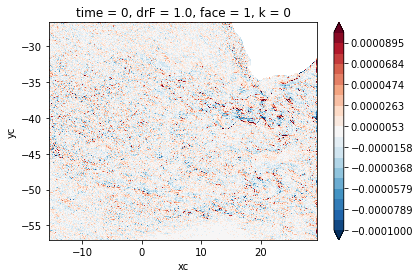

In [39]:
div_unf.isel(time=0).plot(x='xc',y='yc',levels=np.linspace(-0.0001,0.0001,20))
#plt.xlim(15,23)
#plt.ylim(-43,-35)

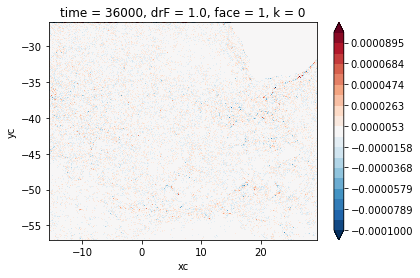

In [38]:
div_eul.isel(time=10).plot(x='xc',y='yc',levels=np.linspace(-0.0001,0.0001,20))

In [11]:
zeta_unf = ((-grid.diff(u_unfiltered * ds.dxC, 'Y') + grid.diff(v_unfiltered * ds.dyC, 'X'))/ds.raZ).assign_coords({"xg": (["i_g"], XG[0,:])}
                                                                 ).assign_coords({"yg": (["j_g"], YG[:,0])})
zeta_eul = ((-grid.diff(u_eul_filtered * ds.dxC, 'Y') + grid.diff(v_eul_filtered * ds.dyC, 'X'))/ds.raZ).assign_coords({"xg": (["i_g"], XG[0,:])}
                                                                 ).assign_coords({"yg": (["j_g"], YG[:,0])})
zeta_filt = ((-grid.diff(u_filtered * ds.dxC, 'Y') + grid.diff(v_filtered * ds.dyC, 'X'))/ds.raZ).assign_coords({"xg": (["i_g"], XG[0,:])}
                                                                 ).assign_coords({"yg": (["j_g"], YG[:,0])})

In [12]:
strain_unf = (((grid.diff(u_unfiltered*ds.dyG, 'X') - grid.diff(v_unfiltered*ds.dxG, 'Y')/ds.raC)**2+(grid.interp(grid.interp((grid.diff(u_unfiltered* ds.dxC, 'Y') + grid.diff(v_unfiltered* ds.dyC, 'X'))/ds.raZ,'X'),'Y')**2))**0.5).assign_coords({"xc": (["i"], XC[0,:])}
                                                                 ).assign_coords({"yc": (["j"], YC[:,0])})
strain_eul = (((grid.diff(u_eul_filtered*ds.dyG, 'X') - grid.diff(v_eul_filtered*ds.dxG, 'Y')/ds.raC)**2+(grid.interp(grid.interp((grid.diff(u_eul_filtered* ds.dxC, 'Y') + grid.diff(v_eul_filtered* ds.dyC, 'X'))/ds.raZ,'X'),'Y')**2))**0.5).assign_coords({"xc": (["i"], XC[0,:])}
                                                                 ).assign_coords({"yc": (["j"], YC[:,0])})
strain_filt = (((grid.diff(u_filtered*ds.dyG, 'X') - grid.diff(v_filtered*ds.dxG, 'Y')/ds.raC)**2+(grid.interp(grid.interp((grid.diff(u_eul_filtered* ds.dxC, 'Y') + grid.diff(v_eul_filtered* ds.dyC, 'X'))/ds.raZ,'X'),'Y')**2))**0.5).assign_coords({"xc": (["i"], XC[0,:])}
                                                                 ).assign_coords({"yc": (["j"], YC[:,0])})

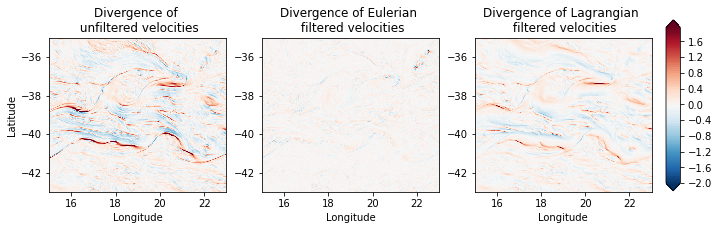

In [30]:
plt.figure(figsize=(10,3.3))
plt.subplot(131)
(div_unf.isel(time=0)*10**4).plot.pcolormesh(x='xc',y='yc',levels=np.arange(-2,2,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,23)
plt.ylim(-43,-35)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Divergence of \n unfiltered velocities')

plt.subplot(132)
(div_eul.isel(time=0)*10**4).plot.pcolormesh(x='xc',y='yc',levels=np.arange(-2,2,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,23)
plt.ylim(-43,-35)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Divergence of Eulerian \n filtered velocities')

plt.subplot(133)
cs=(div_filt.isel(time=0)*10**4).plot.pcolormesh(x='xc',y='yc',levels=np.arange(-2,2,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,23)
plt.ylim(-43,-35)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Divergence of Lagrangian \n filtered velocities')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
fig = plt.gcf()
fig.savefig("divergence_zoom.png")

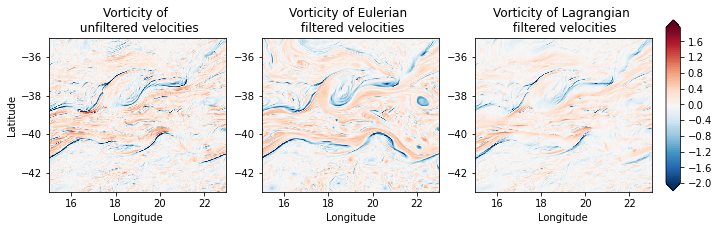

In [32]:
plt.figure(figsize=(10,3.3))
plt.subplot(131)
(zeta_unf.isel(time=0)*10**4).plot.pcolormesh(x='xg',y='yg',levels=np.arange(-2,2,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,23)
plt.ylim(-43,-35)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Vorticity of \n unfiltered velocities')

plt.subplot(132)
(zeta_eul.isel(time=0)*10**4).plot.pcolormesh(x='xg',y='yg',levels=np.arange(-2,2,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,23)
plt.ylim(-43,-35)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Vorticity of Eulerian \n filtered velocities')

plt.subplot(133)
cs=(zeta_filt.isel(time=0)*10**4).plot.pcolormesh(x='xg',y='yg',levels=np.arange(-2,2,0.05),rasterized=True,add_colorbar=False,cmap='RdBu_r')
plt.xlim(15,23)
plt.ylim(-43,-35)
plt.xlabel('Longitude')
plt.ylabel('')
plt.title('Vorticity of Lagrangian \n filtered velocities')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
fig = plt.gcf()
fig.savefig("vorticity_zoom.png")

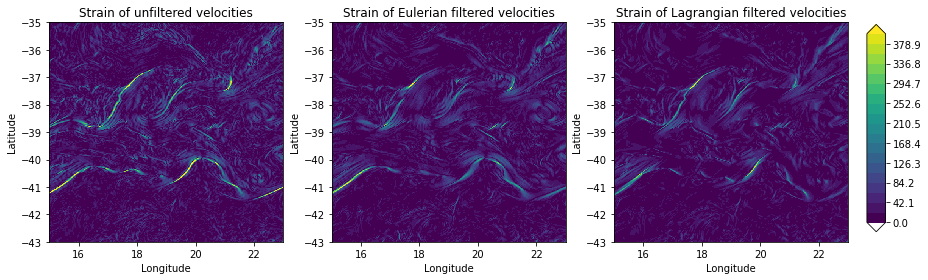

In [20]:
plt.figure(figsize=(13,4))
plt.subplot(131)
strain_unf.isel(time=0).plot.pcolormesh(x='xc',y='yc',levels=np.linspace(0,400,20),rasterized=True,add_colorbar=False)
plt.xlim(15,23)
plt.ylim(-43,-35)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Strain of unfiltered velocities')

plt.subplot(132)
strain_eul.isel(time=0).plot.pcolormesh(x='xc',y='yc',levels=np.linspace(0,400,20),rasterized=True,add_colorbar=False)
plt.xlim(15,23)
plt.ylim(-43,-35)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Strain of Eulerian filtered velocities')

plt.subplot(133)
cs=strain_filt.isel(time=0).plot.pcolormesh(x='xc',y='yc',levels=np.linspace(0,400,20),rasterized=True,add_colorbar=False)
plt.xlim(15,23)
plt.ylim(-43,-35)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Strain of Lagrangian filtered velocities')

fig=plt.gcf()
plt.tight_layout()
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.93, 0.18, 0.02, 0.72])
fig.colorbar(cs, cax=cbar_ax,extend='both')
fig = plt.gcf()
fig.savefig("strain_zoom.png")

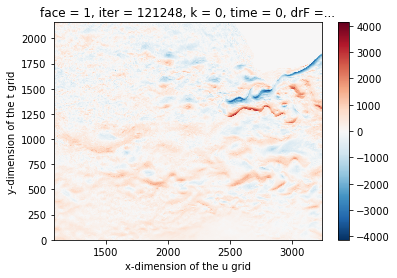

In [74]:
eul_unf_utransport.isel(time=0).plot()

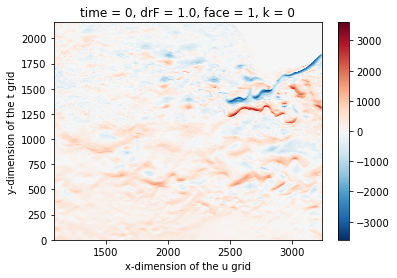

In [75]:
eul_utransport.isel(time=0).plot()